In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

import symmetric_methods as sm


In [2]:
L=2

dim = np.zeros((L+1,))

dim[0] = 100
dim[1] = 70
dim[2] = 40
#dim[3] = 10
#dim[4] = 50
#dim[5] = 50
#dim[6] = 50
#dim[7] = 50
#dim[8] = 50
#dim[9] = 50
#dim[10] = 50

dim= dim.astype(int)

npar = 0
cpar = np.zeros((L+1,))
for iL in range(L):
    npar = npar + dim[iL] * dim[iL+1]
    cpar[iL+1] = npar
npar = npar.astype(int)
cpar = cpar.astype(int)

print(npar)
    
num_train_data = 5000
num_test_data = 5000

noise = 0.0

#num_models = 10
num_models = 1





9800


### Create Neural Network

In [3]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [nn.Linear(dim[0],dim[1],bias=False)]
        for iL in np.arange(1,L):
            layers.append(nn.Linear(dim[iL],dim[iL+1],bias=False))        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)



# Define a custom initialization function using Gaussian distribution
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        # Gaussian initialization 
        y = m.in_features
        nn.init.normal_(m.weight, mean=0.0, std=1./np.sqrt(y)) 
        #nn.init.normal_(m.weight, mean=0.0, std=1.) 


        
        
nets = []
nets0 = []

for _ in range(num_models):
    
    # Create a new model and initialize its weights
    net = Net()
    net.apply(initialize_weights)
    nets.append(net)
    
    # Create a "backup" of the initial weights
    net0 = Net()
    net0.load_state_dict(net.state_dict())  # Copy weights
    nets0.append(net0)



net_teacher = Net()
net_teacher.apply(initialize_weights)

'''
net = Net()
net.apply(initialize_weights)

net0 = Net()
net0.load_state_dict(net.state_dict())
'''

num_parameters = sum(param.numel() for param in net.parameters())
print(num_parameters)


9800


In [ ]:
# print list of all parameter tensors

print(list(nets[0].parameters()))

print(list(nets0[0].parameters()))


### Save model

In [ ]:
#PATH = './mlp_net.pth'
#torch.save(net.state_dict(), PATH)
#PATH = './mlp_net_teacher.pth'
#torch.save(net_teacher.state_dict(), PATH)

#PATH = './mlp_up_net.pth'
#torch.save(net.state_dict(), PATH)
#PATH = './mlp_up_net_teacher.pth'
#torch.save(net_teacher.state_dict(), PATH)


### Load model

In [ ]:

PATH = './mlp_net.pth'
net = Net()
net.load_state_dict(torch.load(PATH))
net0 = Net()
net0.load_state_dict(torch.load(PATH))
PATH = './mlp_net_teacher.pth'
net_teacher = Net()
net_teacher.load_state_dict(torch.load(PATH))


'''
PATH = './mlp_up_net.pth'
net = Net()
net.load_state_dict(torch.load(PATH))
net0 = Net()
net0.load_state_dict(torch.load(PATH))
PATH = './mlp_up_net_teacher.pth'
net_teacher = Net()
net_teacher.load_state_dict(torch.load(PATH))
'''

### Input data

In [4]:
# gradient on linear regression has D ~ (unif)^(1/(1-beta)) --> p(D) ~ D^(-beta) --> Loss(t) ~ t^(beta-2)

D = np.logspace(0,-5,dim[0])
#D = 1./(np.linspace(1,1000,dim[0])**2)
#D = np.linspace(0,1,dim[0])**2

Sigma, R = np.linalg.qr(np.random.normal(np.zeros((dim[0],dim[0])),1))
Sigma = (Sigma * D) @ Sigma.T
inputs_train = torch.from_numpy(np.random.multivariate_normal(np.zeros((dim[0],)),Sigma,size=(num_train_data,))).to(torch.float)
inputs_test = torch.from_numpy(np.random.multivariate_normal(np.zeros((dim[0],)),Sigma,size=(num_test_data,))).to(torch.float)






### Save input

In [ ]:
#PATH = './mlp_inputs_train.pth'
#torch.save(inputs_train, PATH)
#PATH = './mlp_inputs_test.pth'
#torch.save(inputs_test, PATH)

#PATH = './mlp_up_inputs_train.pth'
#torch.save(inputs_train, PATH)
#PATH = './mlp_up_inputs_test.pth'
#torch.save(inputs_test, PATH)



### Load input

In [ ]:

PATH = './mlp_inputs_train.pth'
inputs_train = torch.load(PATH)
PATH = './mlp_inputs_test.pth'
inputs_test = torch.load(PATH)


#PATH = './mlp_up_inputs_train.pth'
#inputs_train = torch.load(PATH)
#PATH = './mlp_up_inputs_test.pth'
#inputs_test = torch.load(PATH)


### Output data

In [5]:

with torch.no_grad():
    labels_train = net_teacher(inputs_train) + torch.from_numpy(noise * np.random.normal(np.zeros((num_train_data,dim[L])),1)).to(torch.float)  
with torch.no_grad():
    labels_test = net_teacher(inputs_test) + torch.from_numpy(noise * np.random.normal(np.zeros((num_test_data,dim[L])),1)).to(torch.float)


### Fit linear model

In [6]:

Wlin = labels_train.T @ np.linalg.pinv(inputs_train).T
outputs_train_lin = ( Wlin @ inputs_train.T ).T
outputs_test_lin = ( Wlin @ inputs_test.T ).T

trainloss_lin = np.linalg.norm(outputs_train_lin-labels_train)**2 / num_train_data / 2
testloss_lin = np.linalg.norm(outputs_test_lin-labels_test)**2 / num_test_data / 2


In [7]:

print(trainloss_lin)
#print('\n')
print(testloss_lin)


1.340845233919488e-12
1.3327255743617023e-12


### Learning rate

In [8]:

lr = .8
nepochs_gd = 1000


### Reset

In [ ]:

for inet in range(num_models):
    nets[inet].load_state_dict(nets0[inet].state_dict())
    

### Training, gradient descent

In [9]:

rec_time = 1
nitera = int(nepochs_gd/rec_time)

running_trainloss_gd = torch.zeros( (nitera,num_models) )
running_testloss_gd = torch.zeros( (nitera,num_models) )

#itera = 0    

for epoch in range(nepochs_gd):  # loop over the dataset multiple times

    if epoch%(nepochs_gd/100) == 0:
        print(epoch)
    #itera += 1

    for inet in range(num_models):
        
        # print statistics
        #if epoch % rec_time == rec_time-1:    # print every 'rec_time' mini-batches

        with torch.no_grad():

            outputs_train = nets[inet](inputs_train)
            running_trainloss_gd[epoch,inet] = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

            outputs_test = nets[inet](inputs_test)
            running_testloss_gd[epoch,inet] = torch.norm(outputs_test-labels_test)**2 / num_test_data / 2

        # Compute the loss
        outputs_train = nets[inet](inputs_train)
        loss = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

        # Compute first-order gradients
        grads = torch.autograd.grad(loss, nets[inet].parameters(), create_graph=False)
        grad_vec_C = torch.cat([g.view(-1) for g in grads])
        
        param_vec = torch.nn.utils.parameters_to_vector(nets[inet].parameters())
        torch.nn.utils.vector_to_parameters( param_vec - lr * grad_vec_C , nets[inet].parameters())    
        
print('Finished Training')

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Finished Training


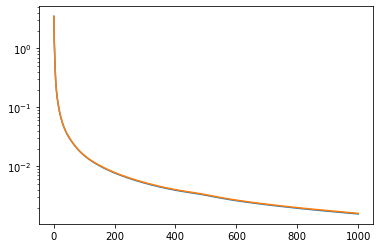

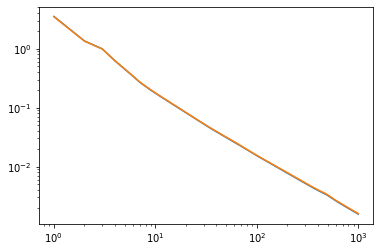

In [10]:

plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd)
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd)
plt.yscale('log')

#plt.ylim(10**(-5),10**(1))
#plt.xlim(1,1000)

plt.show()


plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd)
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd)
plt.xscale('log')
plt.yscale('log')

plt.show()



### Learning rate

In [11]:

lr = 0.01
nepochs_adam = 1000


### Reset

In [12]:

for inet in range(num_models):
    nets[inet].load_state_dict(nets0[inet].state_dict())
    

### Training, Adam

In [13]:

rec_time = 1
nitera = int(nepochs_adam/rec_time)

running_trainloss_adam = torch.zeros( (nitera,num_models) )
running_testloss_adam = torch.zeros( (nitera,num_models) )

#itera = 0    

optimizers = [torch.optim.Adam(nets[inet].parameters(), lr=lr) for inet in range(num_models)]

for epoch in range(nepochs_adam):  # loop over the dataset multiple times

    if epoch%(nepochs_adam/100) == 0:
        print(epoch)
    #itera += 1

    for inet in range(num_models):
        
        # print statistics
        #if epoch % rec_time == rec_time-1:    # print every 'rec_time' mini-batches

        with torch.no_grad():

            outputs_train = nets[inet](inputs_train)
            running_trainloss_adam[epoch,inet] = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

            outputs_test = nets[inet](inputs_test)
            running_testloss_adam[epoch,inet] = torch.norm(outputs_test-labels_test)**2 / num_test_data / 2

        # Compute the loss
        outputs_train = nets[inet](inputs_train)
        loss = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2
        
        optimizers[inet].zero_grad()  # Clear gradients for this model
        loss.backward()              # Compute gradients for this model
        optimizers[inet].step()      # Update parameters for this model

print('Finished Training')

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Finished Training


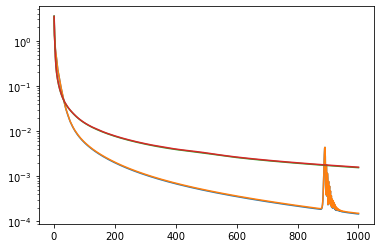

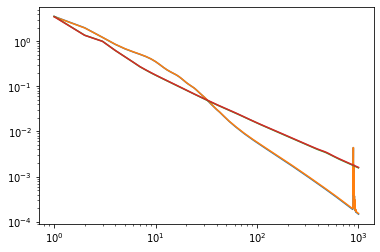

In [14]:

plt.plot(np.arange(1,nepochs_adam+1),running_trainloss_adam)
plt.plot(np.arange(1,nepochs_adam+1),running_testloss_adam)
plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd)
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd)
plt.yscale('log')

#plt.ylim(10**(-5),10**(1))
#plt.xlim(1,1000)

plt.show()


plt.plot(np.arange(1,nepochs_adam+1),running_trainloss_adam)
plt.plot(np.arange(1,nepochs_adam+1),running_testloss_adam)
plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd)
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd)
plt.xscale('log')
plt.yscale('log')

plt.show()


### Learning rate

In [70]:

lr = 0.8
epsilon = 1e-10

sexp = 0.25

nepochs_shampoo = 1000



### Reset

In [71]:

for inet in range(num_models):
    nets[inet].load_state_dict(nets0[inet].state_dict())
    

### Training, Shampoo

In [72]:

rec_time = 1
nitera = int(nepochs_shampoo/rec_time)

running_trainloss_shampoo = torch.zeros((nitera, num_models))
running_testloss_shampoo = torch.zeros((nitera, num_models))

# Initialize Shampoo preconditioners
Lmats = [epsilon*torch.eye(dim[i+1]) for i in range(L)]  # Left preconditioners
Rmats = [epsilon*torch.eye(dim[i]) for i in range(L)]     # Right preconditioners

for epoch in range(nepochs_shampoo):
    if epoch % (nepochs_shampoo/100) == 0:
        print(epoch)
            
    for inet in range(num_models):
        net = nets[inet]
        
        with torch.no_grad():
            outputs_train = net(inputs_train)
            running_trainloss_shampoo[epoch, inet] = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

            outputs_test = net(inputs_test)
            running_testloss_shampoo[epoch, inet] = torch.norm(outputs_test-labels_test)**2 / num_test_data / 2

        # Forward pass
        outputs_train = net(inputs_train)
        loss = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

        # Zero gradients
        net.zero_grad()
        
        # Backward pass
        loss.backward()
        
        # Update parameters with Shampoo
        for i, (name, param) in enumerate(net.named_parameters()):
            if param.grad is None:
                continue
                
            grad = param.grad.data
            if grad.ndim != 2:  # Skip biases or non-matrix parameters
                param.data.add_(grad, alpha=-lr)  # Simple SGD for biases
                continue
                                
            # Update statistics
            Lmats[i].addmm_(grad, grad.T)
            Rmats[i].addmm_(grad.T, grad)
            
            # Compute preconditioners
            # Right preconditioner (R^{-1/4})
            u, s, v = torch.linalg.svd(Rmats[i])
            spow = s.pow(-sexp)
            Rpow = (u * spow.unsqueeze(0)) @ v

            # Left preconditioner (L^{-1/4})
            u, s, v = torch.linalg.svd(Lmats[i])
            spow = s.pow(-sexp)
            Lpow = (u * spow.unsqueeze(0)) @ v

            # Update parameters
            update = Lpow @ grad @ Rpow
            param.data.add_(update, alpha=-lr)
            



print('Finished Training')


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Finished Training


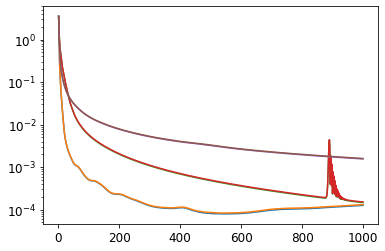

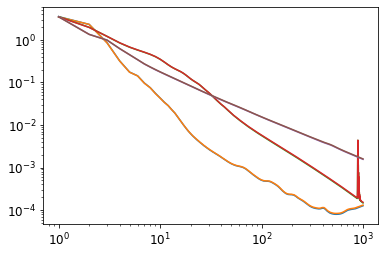

In [73]:

plt.plot(np.arange(1,nepochs_shampoo+1),running_trainloss_shampoo)
plt.plot(np.arange(1,nepochs_shampoo+1),running_testloss_shampoo)
plt.plot(np.arange(1,nepochs_adam+1),running_trainloss_adam)
plt.plot(np.arange(1,nepochs_adam+1),running_testloss_adam)
plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd)
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd)
plt.yscale('log')

#plt.ylim(10**(-5),10**(1))
#plt.xlim(1,1000)

plt.show()


plt.plot(np.arange(1,nepochs_shampoo+1),running_trainloss_shampoo)
plt.plot(np.arange(1,nepochs_shampoo+1),running_testloss_shampoo)
plt.plot(np.arange(1,nepochs_adam+1),running_trainloss_adam)
plt.plot(np.arange(1,nepochs_adam+1),running_testloss_adam)
plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd)
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd)
plt.xscale('log')
plt.yscale('log')

plt.show()




### Learning rate

In [88]:

lr = 0.00001
#lr = 0.0000001

damping = 0.00013
#damping = 0.0000005

update_freq = 1  # How often to update the K-FAC approximation
inverse_freq = 1  # How often to compute inverses
momentum = 0.9

nepochs_kfac = 1000




### Reset

In [89]:

for inet in range(num_models):
    nets[inet].load_state_dict(nets0[inet].state_dict())
    

In [90]:

# Forward hook to capture input
def forward_hook(module, input, output):
    inputs[module] = input[0].detach()

# Backward hook to capture gradients (using full_backward_hook for newer PyTorch versions)
def backward_hook(module, grad_input, grad_output):
    grad_outputs[module] = grad_output[0].detach()


### Training, KFAC

In [91]:

from collections import defaultdict

rec_time = 1
nitera = int(nepochs_kfac/rec_time)

running_trainloss_kfac = torch.zeros( (nitera,num_models) )
running_testloss_kfac = torch.zeros( (nitera,num_models) )

# Initialize K-FAC related variables
inputs = {}
grad_outputs = {}
A_factors = defaultdict(list)  # Input covariance factors
G_factors = defaultdict(list)  # Gradient covariance factors

# Register hooks for all linear layers in each network
for net in nets:
    for layer in net.modules():
        if isinstance(layer, nn.Linear):
            layer.register_forward_hook(forward_hook)
            layer.register_full_backward_hook(backward_hook)


for epoch in range(nepochs_kfac):  # loop over the dataset multiple times
    
    if epoch % (nepochs_kfac/100) == 0:
        print(epoch)
            
    for inet in range(num_models):
        net = nets[inet]
        
        with torch.no_grad():
            outputs_train = net(inputs_train)
            running_trainloss_kfac[epoch, inet] = torch.norm(outputs_train - labels_train)**2 / num_train_data / 2

            outputs_test = net(inputs_test)
            running_testloss_kfac[epoch, inet] = torch.norm(outputs_test - labels_test)**2 / num_test_data / 2

        # Compute the loss
        outputs_train = net(inputs_train)
        loss = torch.norm(outputs_train - labels_train)**2 / num_train_data / 2
        
        # Zero gradients
        net.zero_grad()
        
        # Backward pass
        loss.backward()
        
        # Update K-FAC factors
        if epoch % update_freq == 0:
            for layer in net.modules():
                if isinstance(layer, nn.Linear):
                    # Get input and gradient from hooks
                    a = inputs.get(layer, None)
                    g = grad_outputs.get(layer, None)
                    
                    if a is not None and g is not None:
                        # Compute A factor (input covariance)
                        a = a.unsqueeze(-1) if a.dim() == 1 else a
                        A = torch.matmul(a.transpose(-2, -1), a) / a.size(0)
                        
                        # Compute G factor (gradient covariance)
                        g = g.unsqueeze(-1) if g.dim() == 1 else g
                        G = torch.matmul(g.transpose(-2, -1), g) / g.size(0)
                        
                        # Update running estimates with momentum
                        if epoch == 0:
                            A_factors[layer] = A
                            G_factors[layer] = G
                        else:
                            A_factors[layer] = momentum * A_factors[layer] + (1 - momentum) * A
                            G_factors[layer] = momentum * G_factors[layer] + (1 - momentum) * G
        
        # Compute preconditioned gradients using K-FAC approximation
        if epoch % inverse_freq == 0:
            for layer in net.modules():
                if isinstance(layer, nn.Linear):
                    # Get A and G factors
                    A = A_factors.get(layer, None)
                    G = G_factors.get(layer, None)
                    
                    if A is not None and G is not None:
                        # Add damping
                        A_reg = A + damping * torch.eye(A.size(-1), device=A.device)
                        G_reg = G + damping * torch.eye(G.size(-1), device=G.device)
                        
                        # Compute inverses
                        try:
                            A_inv = torch.inverse(A_reg)
                            G_inv = torch.inverse(G_reg)
                            
                            # Precondition gradients
                            if layer.weight.grad is not None:
                                grad = layer.weight.grad.data
                                grad = torch.matmul(G_inv, torch.matmul(grad, A_inv))
                                layer.weight.grad.data = grad
                            
                            if layer.bias is not None and layer.bias.grad is not None:
                                grad_bias = layer.bias.grad.data.unsqueeze(-1)
                                grad_bias = torch.matmul(G_inv, grad_bias)
                                layer.bias.grad.data = grad_bias.squeeze(-1)
                        except RuntimeError:
                            # Handle singular matrix case
                            pass
        
        # Update parameters
        for param in net.parameters():
            if param.grad is not None:
                param.data -= lr * param.grad.data

print('Finished Training')


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Finished Training


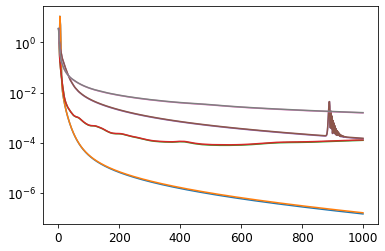

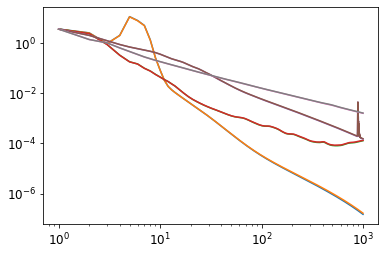

In [92]:

plt.plot(np.arange(1,nepochs_kfac+1),running_trainloss_kfac)
plt.plot(np.arange(1,nepochs_kfac+1),running_testloss_kfac)
plt.plot(np.arange(1,nepochs_shampoo+1),running_trainloss_shampoo)
plt.plot(np.arange(1,nepochs_shampoo+1),running_testloss_shampoo)
plt.plot(np.arange(1,nepochs_adam+1),running_trainloss_adam)
plt.plot(np.arange(1,nepochs_adam+1),running_testloss_adam)
plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd)
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd)
plt.yscale('log')

#plt.ylim(10**(-5),10**(1))
#plt.xlim(1,1000)

plt.show()


plt.plot(np.arange(1,nepochs_kfac+1),running_trainloss_kfac)
plt.plot(np.arange(1,nepochs_kfac+1),running_testloss_kfac)
plt.plot(np.arange(1,nepochs_shampoo+1),running_trainloss_shampoo)
plt.plot(np.arange(1,nepochs_shampoo+1),running_testloss_shampoo)
plt.plot(np.arange(1,nepochs_adam+1),running_trainloss_adam)
plt.plot(np.arange(1,nepochs_adam+1),running_testloss_adam)
plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd)
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd)
plt.xscale('log')
plt.yscale('log')

plt.show()





### Learning rate

In [59]:


#alpha = 0.01
alpha = 0.05

#beta = 0.98
beta = 0.95

eps = 0.

betah = 0.95

nepochs_symo = 500




### Reset

In [60]:

for inet in range(num_models):
    nets[inet].load_state_dict(nets0[inet].state_dict())
    

### Training, ensemble cov

In [61]:

rec_time = 1
nitera = int(nepochs_symo/rec_time)

running_trainloss_symo = torch.zeros( (nitera,num_models) )
running_testloss_symo = torch.zeros( (nitera,num_models) )

#phi_rec = np.zeros((L-2,nepochs_symo,num_models+1))
#PHI1_rec = np.zeros((dim[0],dim[0],nepochs_symo,num_models+1))
#PSI1_rec = np.zeros((dim[0],dim[2],nepochs_symo,num_models+1))
#PHIL_rec = np.zeros((dim[L],dim[L],nepochs_symo,num_models+1))

phi_mom = np.zeros((L-2,num_models))
PHI1_mom = np.zeros((dim[0],dim[0],num_models))
PSI1_mom = np.zeros((dim[0],dim[2],num_models))
PHIL_mom = np.zeros((dim[L],dim[L],num_models))

#grad_rec = np.zeros((num_parameters,num_models))
update_rec = np.zeros((num_parameters,nepochs_symo,num_models))

#itera = 0    

for epoch in range(nepochs_symo):  # loop over the dataset multiple times

    lr = alpha * beta**epoch
    
    if epoch%(nepochs_symo/100) == 0:
        print(epoch)
            
    for inet in range(num_models):
        
        with torch.no_grad():

            outputs_train = nets[inet](inputs_train)
            running_trainloss_symo[epoch,inet] = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

            outputs_test = nets[inet](inputs_test)
            running_testloss_symo[epoch,inet] = torch.norm(outputs_test-labels_test)**2 / num_test_data / 2

        #if epoch%(nepochs_symo/100) == 0:
            #print(running_trainloss_symo[epoch,inet])
        #itera += 1

        # Compute the loss
        outputs_train = nets[inet](inputs_train)
        loss = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

        # Compute first-order gradients
        grads = torch.autograd.grad(loss, nets[inet].parameters(), create_graph=False)

        grad_vec_F = torch.cat([g.T.reshape(-1,1) for g in grads])
        grad_vec_C = torch.cat([g.view(-1) for g in grads])
        
        grad_np = grad_vec_F.numpy()
        #grad_rec[:,inet] = grad_np.reshape((num_parameters,))
        
        #phi_rec[:,epoch,inet],PHI1_rec[:,:,epoch,inet],PSI1_rec[:,:,epoch,inet],PHIL_rec[:,:,epoch,inet] = sm.grad2par(L,dim,grad_np)
        
        '''
            #phi_rec[:,epoch,num_models],PHI1_rec[:,:,epoch,num_models],PSI1_rec[:,:,epoch,num_models],PHIL_rec[:,:,epoch,num_models] = sm.grad2par(L,dim,grad_rec)
            #phi = np.squeeze(phi_rec[:,epoch,num_models])
            #PHI1 = np.squeeze(PHI1_rec[:,:,epoch,num_models])
            #PSI1 = np.squeeze(PSI1_rec[:,:,epoch,num_models])
            #PHIL = np.squeeze(PHIL_rec[:,:,epoch,num_models])

            phi,PHI1,PSI1,PHIL = sm.grad2par(L,dim,grad_rec)

            phi = phi + eps
            PHI1 = PHI1 + eps * np.eye(dim[0])
            PHIL = PHIL + eps * np.eye(dim[L])

            phi,PHI1,PSI1,PHIL = sm.squareroot(L,dim,phi,PHI1,PSI1,PHIL)
            phi,PHI1,PSI1,PHIL = sm.inverse(L,dim,phi,PHI1,PSI1,PHIL)

            for inet in range(num_models):

        '''

        # momentum
        
        phi,PHI1,PSI1,PHIL = sm.grad2par(L,dim,grad_np)
        
        phi_mom[:,inet] = betah * phi_mom[:,inet] + (1-betah) * phi
        PHI1_mom[:,:,inet] = betah * PHI1_mom[:,:,inet] + (1-betah) * PHI1
        PSI1_mom[:,:,inet] = betah * PSI1_mom[:,:,inet] + (1-betah) * PSI1
        PHIL_mom[:,:,inet] = betah * PHIL_mom[:,:,inet] + (1-betah) * PHIL
        
        phi = np.squeeze(phi_mom[:,inet]) / (1-betah**(epoch+1))
        PHI1 = np.squeeze(PHI1_mom[:,:,inet]) / (1-betah**(epoch+1))
        PSI1 = np.squeeze(PSI1_mom[:,:,inet]) / (1-betah**(epoch+1))
        PHIL = np.squeeze(PHIL_mom[:,:,inet]) / (1-betah**(epoch+1))

        phi = phi + eps
        PHI1 = PHI1 + eps * np.eye(dim[0])
        PHIL = PHIL + eps * np.eye(dim[L])

        phi,PHI1,PSI1,PHIL = sm.squareroot(L,dim,phi,PHI1,PSI1,PHIL)
        phi,PHI1,PSI1,PHIL = sm.inverse(L,dim,phi,PHI1,PSI1,PHIL)
       
        #update_F = sm.matvec(L,dim, phi , PHI1 , PSI1 , PHIL , grad_rec[:,inet])
        update_F = sm.matvec(L,dim, phi , PHI1 , PSI1 , PHIL , grad_np)
        update_C = np.copy(update_F)
        
        update_rec[:,epoch,inet] = update_F
        
        for iL in range(L):
            upd = update_F[cpar[iL]:cpar[iL+1]].reshape((dim[iL+1],dim[iL]),order='F')
            update_C[cpar[iL]:cpar[iL+1]]=np.reshape(upd,(dim[iL+1]*dim[iL],),order='C')

        param_vec = torch.nn.utils.parameters_to_vector(nets[inet].parameters())
        torch.nn.utils.vector_to_parameters( param_vec - lr * torch.tensor(update_C).float() , nets[inet].parameters())    


print('Finished Training')


0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
Finished Training


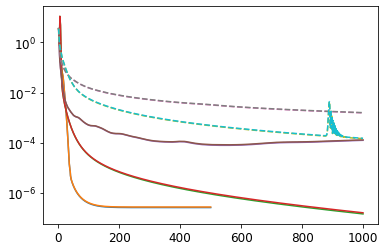

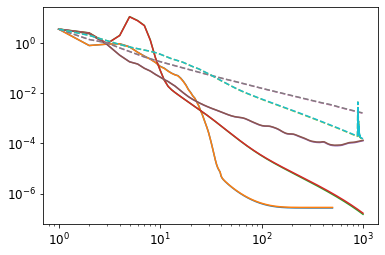

In [93]:

plt.plot(np.arange(1,nepochs_symo+1),running_trainloss_symo)
plt.plot(np.arange(1,nepochs_symo+1),running_testloss_symo)

plt.plot(np.arange(1,nepochs_kfac+1),running_trainloss_kfac)
plt.plot(np.arange(1,nepochs_kfac+1),running_testloss_kfac)

plt.plot(np.arange(1,nepochs_shampoo+1),running_trainloss_shampoo)
plt.plot(np.arange(1,nepochs_shampoo+1),running_testloss_shampoo)

plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd,linestyle='dashed')
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd,linestyle='dashed')

plt.plot(np.arange(1,nepochs_adam+1),running_trainloss_adam,linestyle='dashed')
plt.plot(np.arange(1,nepochs_adam+1),running_testloss_adam,linestyle='dashed')

#plt.xscale('log')
plt.yscale('log')

#plt.ylim(10**(-5),10**(1))
#plt.xlim(0,50)

plt.show()



plt.plot(np.arange(1,nepochs_symo+1),running_trainloss_symo)
plt.plot(np.arange(1,nepochs_symo+1),running_testloss_symo)

plt.plot(np.arange(1,nepochs_kfac+1),running_trainloss_kfac)
plt.plot(np.arange(1,nepochs_kfac+1),running_testloss_kfac)

plt.plot(np.arange(1,nepochs_shampoo+1),running_trainloss_shampoo)
plt.plot(np.arange(1,nepochs_shampoo+1),running_testloss_shampoo)

plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd,linestyle='dashed')
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd,linestyle='dashed')

plt.plot(np.arange(1,nepochs_adam+1),running_trainloss_adam,linestyle='dashed')
plt.plot(np.arange(1,nepochs_adam+1),running_testloss_adam,linestyle='dashed')

plt.xscale('log')
plt.yscale('log')

plt.show()


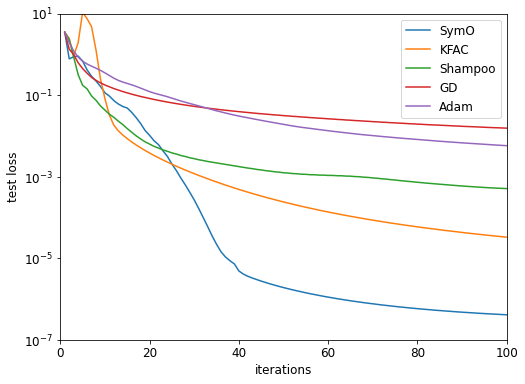

In [98]:

plt.rc('font', size = 12)

plt.plot(np.arange(1,nepochs_symo+1),running_testloss_symo[:,0], label='SymO')
plt.plot(np.arange(1,nepochs_kfac+1),running_testloss_kfac[:,0], label='KFAC')
plt.plot(np.arange(1,nepochs_shampoo+1),running_testloss_shampoo[:,0], label='Shampoo')
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd[:,0], label='GD')
plt.plot(np.arange(1,nepochs_adam+1),running_testloss_adam[:,0], label='Adam')

#plt.xscale('log')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('test loss')

plt.ylim(10**(-7),10**(1))
plt.xlim(0,100)

plt.legend()

fig = plt.gcf()
fig.set_size_inches(8, 6)

#plt.savefig('optimization_linear.pdf',bbox_inches="tight")

plt.show()




In [35]:


inet = 0

varupd = np.zeros((L,nepochs_symo))

for iL in range(L):
    for epoch in range(nepochs_symo):
        varupd[iL,epoch] = np.var(update_rec[cpar[iL]:cpar[iL+1],epoch,inet])



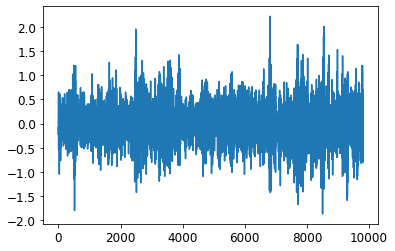

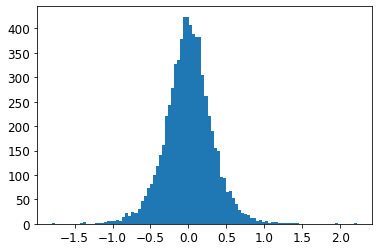

0.31522826824303063


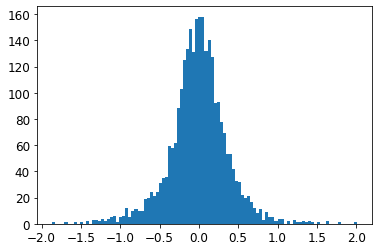

0.37191626458279553


In [36]:

epoch = 100
inet = 0

plt.plot(update_rec[:,epoch,inet])
plt.show()

for iL in range(L):
    plt.hist(update_rec[cpar[iL]:cpar[iL+1],epoch,inet],100)
    plt.show()

    print(np.sqrt(varupd[iL,epoch]))


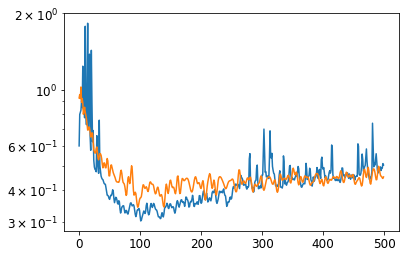

In [37]:

plt.plot(np.sqrt(varupd).T)
plt.yscale('log')
plt.show()


### Hyperparameter tuning, Shampoo

In [ ]:

nepochs_ht_shampoo = 100

nlr = 10
neps = 10

#lrvec = np.linspace(0.1,1.,nlr)
lrvec = np.logspace(-1.,1.,nlr)
epsvec = np.logspace(-18,0,neps)

rec_time = 1
nitera = int(nepochs_ht_shampoo/rec_time)

running_trainloss_ht_shampoo = torch.zeros( (nlr,neps,nitera,num_models) )
running_testloss_ht_shampoo = torch.zeros( (nlr,neps,nitera,num_models) )

for ilr, lr in enumerate(lrvec):
    for ieps, epsilon in enumerate(epsvec):

        print(lr)
        print(epsilon)

        for inet in range(num_models):
            nets[inet].load_state_dict(nets0[inet].state_dict())

        # Initialize Shampoo preconditioners
        Lmats = [epsilon*torch.eye(dim[i+1]) for i in range(L)]  # Left preconditioners
        Rmats = [epsilon*torch.eye(dim[i]) for i in range(L)]     # Right preconditioners

        for epoch in range(nepochs_ht_shampoo):
            if epoch % (nepochs_ht_shampoo/100) == 0:
                print(epoch)

            for inet in range(num_models):
                net = nets[inet]

                with torch.no_grad():
                    outputs_train = net(inputs_train)
                    running_trainloss_ht_shampoo[ilr, ieps, epoch, inet] = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

                    outputs_test = net(inputs_test)
                    running_testloss_ht_shampoo[ilr, ieps, epoch, inet] = torch.norm(outputs_test-labels_test)**2 / num_test_data / 2

                # Forward pass
                outputs_train = net(inputs_train)
                loss = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

                # Zero gradients
                net.zero_grad()

                # Backward pass
                loss.backward()

                # Update parameters with Shampoo
                for i, (name, param) in enumerate(net.named_parameters()):
                    if param.grad is None:
                        continue

                    grad = param.grad.data
                    if grad.ndim != 2:  # Skip biases or non-matrix parameters
                        param.data.add_(grad, alpha=-lr)  # Simple SGD for biases
                        continue

                    # Update statistics
                    Lmats[i].addmm_(grad, grad.T)
                    Rmats[i].addmm_(grad.T, grad)

                    # Compute preconditioners
                    # Right preconditioner (R^{-1/4})
                    u, s, v = torch.linalg.svd(Rmats[i])
                    spow = s.pow(-sexp)
                    Rpow = (u * spow.unsqueeze(0)) @ v

                    # Left preconditioner (L^{-1/4})
                    u, s, v = torch.linalg.svd(Lmats[i])
                    spow = s.pow(-sexp)
                    Lpow = (u * spow.unsqueeze(0)) @ v

                    # Update parameters
                    update = Lpow @ grad @ Rpow
                    param.data.add_(update, alpha=-lr)


    print('\n')



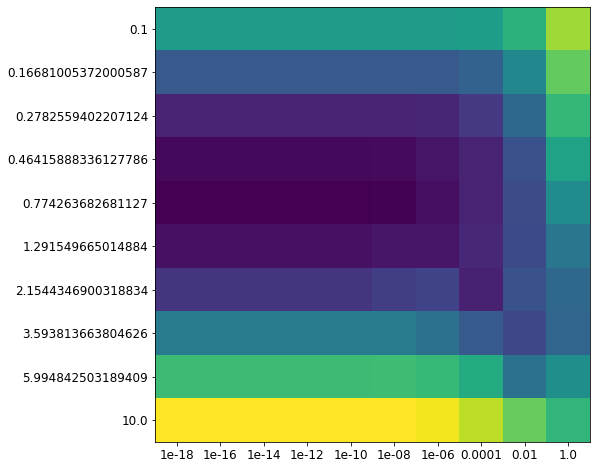

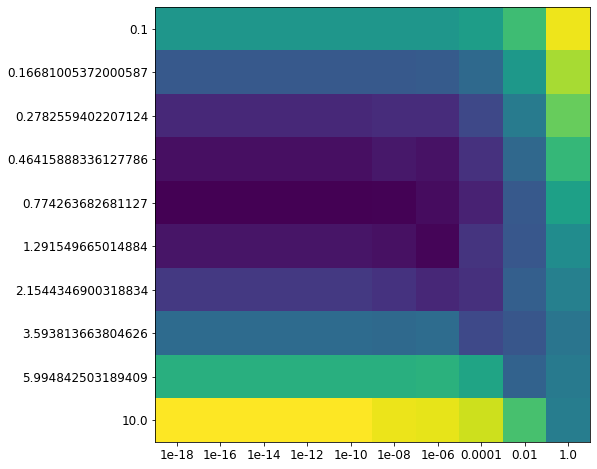

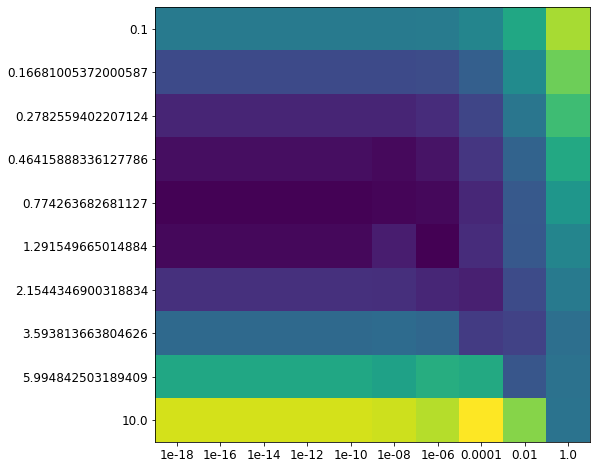

tensor([[0.0077, 0.0077, 0.0077, 0.0077, 0.0077, 0.0077, 0.0078, 0.0101, 0.0260,
         0.1575],
        [0.0023, 0.0023, 0.0023, 0.0023, 0.0023, 0.0023, 0.0024, 0.0037, 0.0123,
         0.0852],
        [0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0012, 0.0020, 0.0067,
         0.0472],
        [0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0006, 0.0007, 0.0014, 0.0042,
         0.0273],
        [0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0006, 0.0006, 0.0011, 0.0032,
         0.0164],
        [0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0009, 0.0005, 0.0012, 0.0031,
         0.0102],
        [0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0010, 0.0009, 0.0023,
         0.0076],
        [0.0048, 0.0048, 0.0048, 0.0048, 0.0048, 0.0051, 0.0046, 0.0016, 0.0019,
         0.0057],
        [0.0256, 0.0256, 0.0256, 0.0256, 0.0256, 0.0221, 0.0306, 0.0277, 0.0029,
         0.0061],
        [0.2416, 0.2416, 0.2416, 0.2416, 0.2416, 0.2253, 0.1763, 0.3681, 0.1120,
         0.0062]])
tensor(0.

In [54]:

plt.figure(figsize=(8,8))
plt.imshow(np.log(np.squeeze(running_testloss_ht_shampoo[:,:,24,0])))
plt.xticks(np.arange(neps),epsvec)
plt.yticks(np.arange(nlr),lrvec)
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(np.log(np.squeeze(running_testloss_ht_shampoo[:,:,49,0])))
plt.xticks(np.arange(neps),epsvec)
plt.yticks(np.arange(nlr),lrvec)
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(np.log(np.squeeze(running_testloss_ht_shampoo[:,:,99,0])))
plt.xticks(np.arange(neps),epsvec)
plt.yticks(np.arange(nlr),lrvec)
plt.show()


print(np.squeeze(running_testloss_ht_shampoo[:,:,99,0]))


print(torch.min(running_testloss_ht_shampoo[:,:,99,0]))


print(lrvec)
print(epsvec)


### Hyperparameter tuning, KFAC

In [79]:

from collections import defaultdict

update_freq = 1  # How often to update the K-FAC approximation
inverse_freq = 1  # How often to compute inverses
momentum = 0.9

nepochs_ht_kfac = 100

nlr = 10
ndamp = 10

lrvec = np.logspace(-9,0,nlr)
dampvec = np.logspace(0,2,ndamp)

rec_time = 1
nitera = int(nepochs_ht_kfac/rec_time)

running_trainloss_ht_kfac = torch.zeros( (nlr,ndamp,nitera,num_models) )
running_testloss_ht_kfac = torch.zeros( (nlr,ndamp,nitera,num_models) )

for ilr, lr in enumerate(lrvec):
    for idamp, damp in enumerate(dampvec):
        
        damping = lr * damp
        #damping = damp

        print(lr)
        print(damping)

        for inet in range(num_models):
            nets[inet].load_state_dict(nets0[inet].state_dict())

        # Initialize K-FAC related variables
        inputs = {}
        grad_outputs = {}
        A_factors = defaultdict(list)  # Input covariance factors
        G_factors = defaultdict(list)  # Gradient covariance factors

        # Register hooks for all linear layers in each network
        for net in nets:
            for layer in net.modules():
                if isinstance(layer, nn.Linear):
                    layer.register_forward_hook(forward_hook)
                    layer.register_full_backward_hook(backward_hook)


        for epoch in range(nepochs_ht_kfac):  # loop over the dataset multiple times

            if epoch % (nepochs_ht_kfac/100) == 0:
                print(epoch)

            for inet in range(num_models):
                net = nets[inet]

                with torch.no_grad():
                    outputs_train = net(inputs_train)
                    running_trainloss_ht_kfac[ilr, idamp, epoch, inet] = torch.norm(outputs_train - labels_train)**2 / num_train_data / 2

                    outputs_test = net(inputs_test)
                    running_testloss_ht_kfac[ilr, idamp, epoch, inet] = torch.norm(outputs_test - labels_test)**2 / num_test_data / 2

                # Compute the loss
                outputs_train = net(inputs_train)
                loss = torch.norm(outputs_train - labels_train)**2 / num_train_data / 2

                # Zero gradients
                net.zero_grad()

                # Backward pass
                loss.backward()

                # Update K-FAC factors
                if epoch % update_freq == 0:
                    for layer in net.modules():
                        if isinstance(layer, nn.Linear):
                            # Get input and gradient from hooks
                            a = inputs.get(layer, None)
                            g = grad_outputs.get(layer, None)

                            if a is not None and g is not None:
                                # Compute A factor (input covariance)
                                a = a.unsqueeze(-1) if a.dim() == 1 else a
                                A = torch.matmul(a.transpose(-2, -1), a) / a.size(0)

                                # Compute G factor (gradient covariance)
                                g = g.unsqueeze(-1) if g.dim() == 1 else g
                                G = torch.matmul(g.transpose(-2, -1), g) / g.size(0)

                                # Update running estimates with momentum
                                if epoch == 0:
                                    A_factors[layer] = A
                                    G_factors[layer] = G
                                else:
                                    A_factors[layer] = momentum * A_factors[layer] + (1 - momentum) * A
                                    G_factors[layer] = momentum * G_factors[layer] + (1 - momentum) * G

                # Compute preconditioned gradients using K-FAC approximation
                if epoch % inverse_freq == 0:
                    for layer in net.modules():
                        if isinstance(layer, nn.Linear):
                            # Get A and G factors
                            A = A_factors.get(layer, None)
                            G = G_factors.get(layer, None)

                            if A is not None and G is not None:
                                # Add damping
                                A_reg = A + damping * torch.eye(A.size(-1), device=A.device)
                                G_reg = G + damping * torch.eye(G.size(-1), device=G.device)

                                # Compute inverses
                                try:
                                    A_inv = torch.inverse(A_reg)
                                    G_inv = torch.inverse(G_reg)

                                    # Precondition gradients
                                    if layer.weight.grad is not None:
                                        grad = layer.weight.grad.data
                                        grad = torch.matmul(G_inv, torch.matmul(grad, A_inv))
                                        layer.weight.grad.data = grad

                                    if layer.bias is not None and layer.bias.grad is not None:
                                        grad_bias = layer.bias.grad.data.unsqueeze(-1)
                                        grad_bias = torch.matmul(G_inv, grad_bias)
                                        layer.bias.grad.data = grad_bias.squeeze(-1)
                                except RuntimeError:
                                    # Handle singular matrix case
                                    pass

                # Update parameters
                for param in net.parameters():
                    if param.grad is not None:
                        param.data -= lr * param.grad.data


    print('\n')



1e-09
1e-09
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1e-09
1.668100537200059e-09
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1e-09
2.782559402207125e-09
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1e-09
4.641588833612779e-09
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14

99
1e-07
2.154434690031883e-06
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1e-07
3.5938136638046257e-06
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1e-07
5.994842503189409e-06
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1e-07
9.999999999999999e-06
0
1
2
3
4
5
6


93
94
95
96
97
98
99
0.0001
0.00027825594022071247
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.0001
0.00046415888336127784
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.0001
0.000774263682681127
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.0001
0.001291549665

11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.01
1.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


0.1
0.1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.1
0.1668100537200059
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
4

/Users/alberto/opt/anaconda3/envs/my-torch/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


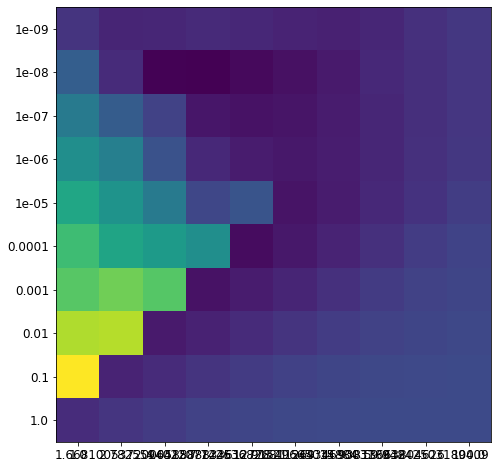

/Users/alberto/opt/anaconda3/envs/my-torch/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in log
  if __name__ == '__main__':


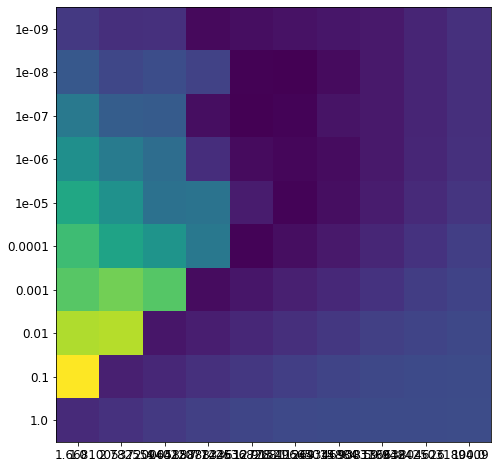

/Users/alberto/opt/anaconda3/envs/my-torch/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in log
  from ipykernel import kernelapp as app


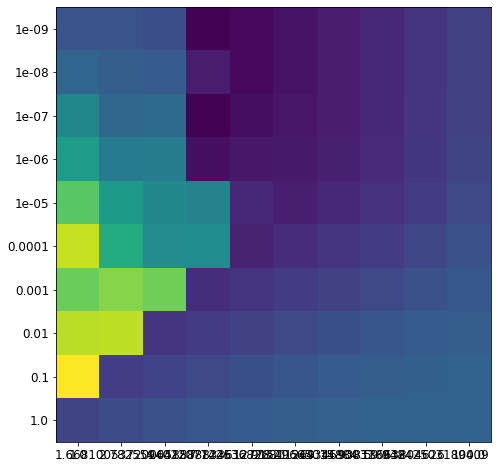

tensor([[1.9022e-01, 1.7683e-01, 6.8395e-02, 6.7869e-07, 1.6278e-06, 6.0251e-06,
         2.2945e-05, 1.1704e-04, 1.0747e-03, 7.9928e-03],
        [4.3983e+00, 1.4132e+00, 6.5387e-01, 2.7495e-05, 1.6831e-06, 6.0171e-06,
         2.1929e-05, 1.2546e-04, 1.0784e-03, 7.5784e-03],
        [3.0338e+03, 5.3859e+00, 1.3877e+01, 5.1527e-07, 3.4611e-06, 1.0103e-05,
         2.6085e-05, 1.4378e-04, 1.1855e-03, 8.3714e-03],
        [3.3329e+05, 3.5499e+02, 5.8207e+02, 4.0548e-06, 1.1826e-05, 1.9270e-05,
         4.1321e-05, 2.1248e-04, 1.5306e-03, 1.1004e-02],
        [2.7637e+09, 2.0248e+05, 4.2097e+03, 1.7564e+03, 1.2318e-04, 3.2298e-05,
         1.3499e-04, 5.4061e-04, 3.2698e-03, 2.3796e-02],
        [1.4602e+13, 6.7282e+06, 9.9293e+03, 1.1708e+04, 7.0597e-05, 2.7006e-04,
         9.4917e-04, 3.4041e-03, 1.6279e-02, 9.6709e-02],
        [1.3252e+10, 1.3967e+11, 2.3747e+10, 2.9100e-04, 9.2200e-04, 2.7648e-03,
         8.1386e-03, 2.6216e-02, 1.0695e-01, 3.8935e-01],
        [6.3651e+12, 9.4800

In [80]:

plt.figure(figsize=(8,8))
plt.imshow(np.log(np.squeeze(running_testloss_ht_kfac[:,:,24,0])))
plt.xticks(np.arange(ndamp),dampvec)
plt.yticks(np.arange(nlr),lrvec)
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(np.log(np.squeeze(running_testloss_ht_kfac[:,:,49,0])))
plt.xticks(np.arange(ndamp),dampvec)
plt.yticks(np.arange(nlr),lrvec)
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(np.log(np.squeeze(running_testloss_ht_kfac[:,:,99,0])))
plt.xticks(np.arange(ndamp),dampvec)
plt.yticks(np.arange(nlr),lrvec)
plt.show()



print(np.squeeze(running_testloss_ht_kfac[:,:,99,0]))


print(torch.min(running_testloss_ht_kfac[:,:,99,0]))


print(lrvec)

print(dampvec)


### Hyperparameter tuning, learning rate

In [ ]:

nepochs_lr = 500

nlr = 10

lrvec = np.logspace(-4,-1,nlr)

rec_time = 1
nitera = int(nepochs_lr/rec_time)

running_trainloss_lr = torch.zeros( (nlr,nitera,num_models) )
running_testloss_lr = torch.zeros( (nlr,nitera,num_models) )

for ilr, lr in enumerate(lrvec):

    print(lr)

    for inet in range(num_models):
        nets[inet].load_state_dict(nets0[inet].state_dict())
        
    phi_mom = np.zeros((L-2,num_models))
    PHI1_mom = np.zeros((dim[0],dim[0],num_models))
    PSI1_mom = np.zeros((dim[0],dim[2],num_models))
    PHIL_mom = np.zeros((dim[L],dim[L],num_models))

    #itera = 0    

    for epoch in range(nepochs_lr):  # loop over the dataset multiple times

        if epoch%(nepochs_lr/100) == 0:
            print(epoch)

        for inet in range(num_models):

            with torch.no_grad():

                outputs_train = nets[inet](inputs_train)
                running_trainloss_lr[ilr,epoch,inet] = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

                outputs_test = nets[inet](inputs_test)
                running_testloss_lr[ilr,epoch,inet] = torch.norm(outputs_test-labels_test)**2 / num_test_data / 2

            #itera += 1

            # Compute the loss
            outputs_train = nets[inet](inputs_train)
            loss = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

            # Compute first-order gradients
            grads = torch.autograd.grad(loss, nets[inet].parameters(), create_graph=False)

            grad_vec_F = torch.cat([g.T.reshape(-1,1) for g in grads])
            #grad_vec_C = torch.cat([g.view(-1) for g in grads])

            grad_np = grad_vec_F.numpy()

            phi,PHI1,PSI1,PHIL = sm.grad2par(L,dim,grad_np)

            phi_mom[:,inet] = betah * phi_mom[:,inet] + (1-betah) * phi
            PHI1_mom[:,:,inet] = betah * PHI1_mom[:,:,inet] + (1-betah) * PHI1
            PSI1_mom[:,:,inet] = betah * PSI1_mom[:,:,inet] + (1-betah) * PSI1
            PHIL_mom[:,:,inet] = betah * PHIL_mom[:,:,inet] + (1-betah) * PHIL

            phi = np.squeeze(phi_mom[:,inet]) / (1-betah**(epoch+1))
            PHI1 = np.squeeze(PHI1_mom[:,:,inet]) / (1-betah**(epoch+1))
            PSI1 = np.squeeze(PSI1_mom[:,:,inet]) / (1-betah**(epoch+1))
            PHIL = np.squeeze(PHIL_mom[:,:,inet]) / (1-betah**(epoch+1))

            phi = phi + eps
            PHI1 = PHI1 + eps * np.eye(dim[0])
            PHIL = PHIL + eps * np.eye(dim[L])

            phi,PHI1,PSI1,PHIL = sm.squareroot(L,dim,phi,PHI1,PSI1,PHIL)
            phi,PHI1,PSI1,PHIL = sm.inverse(L,dim,phi,PHI1,PSI1,PHIL)

            update_F = sm.matvec(L,dim,phi,PHI1,PSI1,PHIL,grad_np)
            update_C = np.copy(update_F)

            for iL in range(L):
                upd = update_F[cpar[iL]:cpar[iL+1]].reshape((dim[iL+1],dim[iL]),order='F')
                update_C[cpar[iL]:cpar[iL+1]]=np.reshape(upd,(dim[iL+1]*dim[iL],),order='C')

            param_vec = torch.nn.utils.parameters_to_vector(nets[inet].parameters())
            torch.nn.utils.vector_to_parameters( param_vec - lr * torch.tensor(update_C).float() , nets[inet].parameters())    

    print('\n')




In [ ]:



for ilr in range(nlr):
    for inet in range(num_models):
        plt.plot(np.arange(1,nepochs_lr+1),running_trainloss_lr[ilr,:,inet])
        plt.plot(np.arange(1,nepochs_lr+1),running_testloss_lr[ilr,:,inet])

plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd,linestyle='dashed')
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd,linestyle='dashed')

#plt.xscale('log')
plt.yscale('log')

#plt.ylim(10**(-5),10**(1))
#plt.xlim(0,50)

plt.show()



for ilr in range(nlr):
    for inet in range(num_models):
        plt.plot(np.arange(1,nepochs_lr+1),running_trainloss_lr[ilr,:,inet])
        plt.plot(np.arange(1,nepochs_lr+1),running_testloss_lr[ilr,:,inet])

plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd,linestyle='dashed')
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd,linestyle='dashed')

plt.xscale('log')
plt.yscale('log')

plt.show()




In [ ]:

print(lrvec)
print('\n')
print(1/lrvec)


### Hyperparameter tuning, learning rate and decay

In [57]:

nepochs_decay = 100

nalpha = 10
nbeta = 10

alphavec = np.logspace(-3,-0.5,nalpha)
betavec = 1 - np.logspace(-3,-0.5,nbeta)

rec_time = 1
nitera = int(nepochs_decay/rec_time)

running_trainloss_decay = torch.zeros( (nalpha,nbeta,nitera,num_models) )
running_testloss_decay = torch.zeros( (nalpha,nbeta,nitera,num_models) )

for ialpha, alpha in enumerate(alphavec):
    for ibeta, beta in enumerate(betavec):

        print(alpha)
        print(beta)

        for inet in range(num_models):
            nets[inet].load_state_dict(nets0[inet].state_dict())

        phi_mom = np.zeros((L-2,num_models))
        PHI1_mom = np.zeros((dim[0],dim[0],num_models))
        PSI1_mom = np.zeros((dim[0],dim[2],num_models))
        PHIL_mom = np.zeros((dim[L],dim[L],num_models))

        #itera = 0    

        for epoch in range(nepochs_decay):  # loop over the dataset multiple times

            lr = alpha * beta**epoch

            if epoch%(nepochs_decay/100) == 0:
                print(epoch)

            for inet in range(num_models):

                with torch.no_grad():

                    outputs_train = nets[inet](inputs_train)
                    running_trainloss_decay[ialpha,ibeta,epoch,inet] = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

                    outputs_test = nets[inet](inputs_test)
                    running_testloss_decay[ialpha,ibeta,epoch,inet] = torch.norm(outputs_test-labels_test)**2 / num_test_data / 2

                #itera += 1

                # Compute the loss
                outputs_train = nets[inet](inputs_train)
                loss = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

                # Compute first-order gradients
                grads = torch.autograd.grad(loss, nets[inet].parameters(), create_graph=False)

                grad_vec_F = torch.cat([g.T.reshape(-1,1) for g in grads])
                #grad_vec_C = torch.cat([g.view(-1) for g in grads])

                grad_np = grad_vec_F.numpy()

                phi,PHI1,PSI1,PHIL = sm.grad2par(L,dim,grad_np)

                phi_mom[:,inet] = betah * phi_mom[:,inet] + (1-betah) * phi
                PHI1_mom[:,:,inet] = betah * PHI1_mom[:,:,inet] + (1-betah) * PHI1
                PSI1_mom[:,:,inet] = betah * PSI1_mom[:,:,inet] + (1-betah) * PSI1
                PHIL_mom[:,:,inet] = betah * PHIL_mom[:,:,inet] + (1-betah) * PHIL

                phi = np.squeeze(phi_mom[:,inet]) / (1-betah**(epoch+1))
                PHI1 = np.squeeze(PHI1_mom[:,:,inet]) / (1-betah**(epoch+1))
                PSI1 = np.squeeze(PSI1_mom[:,:,inet]) / (1-betah**(epoch+1))
                PHIL = np.squeeze(PHIL_mom[:,:,inet]) / (1-betah**(epoch+1))

                phi = phi + eps
                PHI1 = PHI1 + eps * np.eye(dim[0])
                PHIL = PHIL + eps * np.eye(dim[L])

                phi,PHI1,PSI1,PHIL = sm.squareroot(L,dim,phi,PHI1,PSI1,PHIL)
                phi,PHI1,PSI1,PHIL = sm.inverse(L,dim,phi,PHI1,PSI1,PHIL)

                update_F = sm.matvec(L,dim,phi,PHI1,PSI1,PHIL,grad_np)
                update_C = np.copy(update_F)

                for iL in range(L):
                    upd = update_F[cpar[iL]:cpar[iL+1]].reshape((dim[iL+1],dim[iL]),order='F')
                    update_C[cpar[iL]:cpar[iL+1]]=np.reshape(upd,(dim[iL+1]*dim[iL],),order='C')

                param_vec = torch.nn.utils.parameters_to_vector(nets[inet].parameters())
                torch.nn.utils.vector_to_parameters( param_vec - lr * torch.tensor(update_C).float() , nets[inet].parameters())    

    print('\n')





0.001
0.999
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.001
0.9981042643475936
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.001
0.9964061863361954
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.001
0.9931870793094204
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17

33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.003593813663804626
0.9535841116638722
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.003593813663804626
0.9120077456430893
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.003593813663804626
0.8331899462799941
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
3

43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.024484367468222266
0.9981042643475936
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.024484367468222266
0.9964061863361954
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.024484367468222266
0.9931870793094204
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
4

46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.08799225435691074
0.9535841116638722
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.08799225435691074
0.9120077456430893
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.08799225435691074
0.8331899462799941
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
5

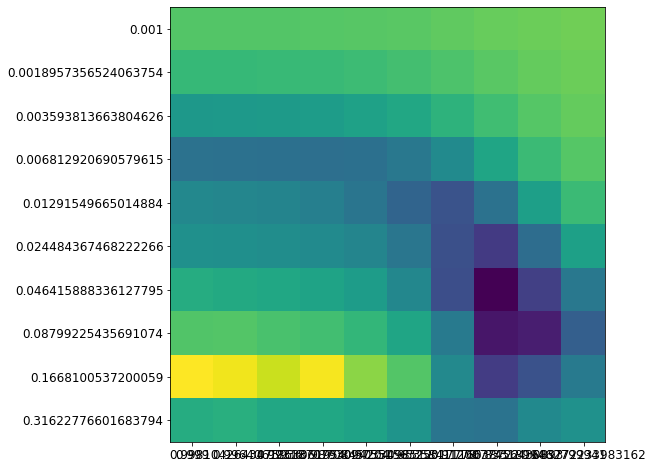

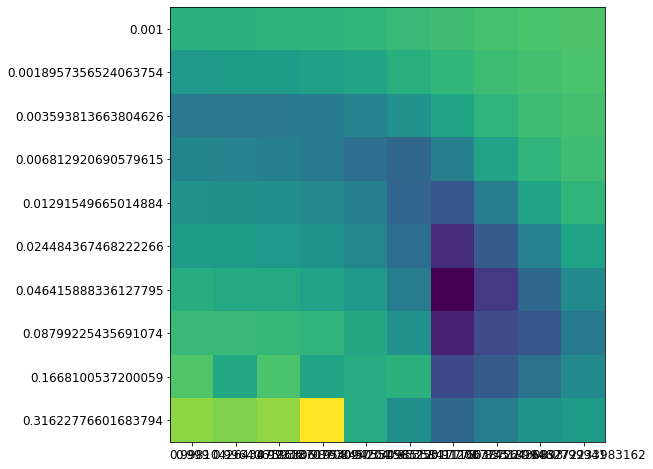

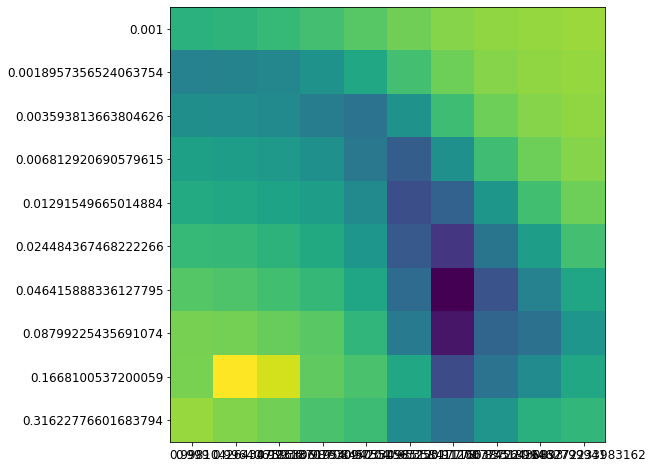

tensor([[5.7944e-02, 7.1702e-02, 1.0379e-01, 1.8669e-01, 4.1157e-01, 9.3666e-01,
         1.7297e+00, 2.4351e+00, 2.8930e+00, 3.1601e+00],
        [1.4459e-03, 1.5379e-03, 2.1025e-03, 5.1506e-03, 2.7013e-02, 1.9782e-01,
         8.3450e-01, 1.7276e+00, 2.4372e+00, 2.8930e+00],
        [4.2224e-03, 3.4291e-03, 2.5472e-03, 9.8393e-04, 4.3251e-04, 5.6522e-03,
         1.5268e-01, 8.4132e-01, 1.7342e+00, 2.4377e+00],
        [1.5255e-02, 1.3810e-02, 9.4898e-03, 4.2784e-03, 6.4569e-04, 8.8402e-05,
         4.4007e-03, 1.6490e-01, 8.5623e-01, 1.7369e+00],
        [3.4142e-02, 2.7089e-02, 1.9822e-02, 1.2031e-02, 2.7383e-03, 3.0721e-05,
         1.2416e-04, 7.4422e-03, 1.8177e-01, 8.6638e-01],
        [1.1047e-01, 9.7003e-02, 6.8016e-02, 3.2597e-02, 6.6924e-03, 6.4775e-05,
         6.2778e-06, 4.9632e-04, 1.2890e-02, 1.9975e-01],
        [3.8816e-01, 3.1139e-01, 1.7631e-01, 1.0212e-01, 2.4027e-02, 2.4105e-04,
         3.1540e-07, 4.1812e-05, 1.4350e-03, 2.3394e-02],
        [1.1229e+00, 1.0407

In [58]:
plt.figure(figsize=(8,8))
plt.imshow(np.log(np.squeeze(running_testloss_decay[:,:,24,0])))
plt.xticks(np.arange(nbeta),betavec)
plt.yticks(np.arange(nalpha),alphavec)
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(np.log(np.squeeze(running_testloss_decay[:,:,49,0])))
plt.xticks(np.arange(nbeta),betavec)
plt.yticks(np.arange(nalpha),alphavec)
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(np.log(np.squeeze(running_testloss_decay[:,:,99,0])))
plt.xticks(np.arange(nbeta),betavec)
plt.yticks(np.arange(nalpha),alphavec)
plt.show()



print(np.squeeze(running_testloss_decay[:,:,99,0]))


print(torch.min(running_testloss_decay[:,:,99,0]))



print(alphavec)

print(betavec)


In [ ]:

for ialpha in range(nalpha):
    for ibeta in range(nbeta):
        for inet in range(num_models):
            plt.plot(np.arange(1,nepochs_decay+1),running_trainloss_decay[ialpha,ibeta,:,inet])
            plt.plot(np.arange(1,nepochs_decay+1),running_testloss_decay[ialpha,ibeta,:,inet])

    plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd,linestyle='dashed')
    plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd,linestyle='dashed')

    #plt.xscale('log')
    plt.yscale('log')

    plt.show()



for ialpha in range(nalpha):
    for ibeta in range(nbeta):
        for inet in range(num_models):
            plt.plot(np.arange(1,nepochs_decay+1),running_trainloss_decay[ialpha,ibeta,:,inet])
            plt.plot(np.arange(1,nepochs_decay+1),running_testloss_decay[ialpha,ibeta,:,inet])

    plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd,linestyle='dashed')
    plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd,linestyle='dashed')

    plt.xscale('log')
    plt.yscale('log')

    plt.show()



In [ ]:

print(alphavec)
print('\n')
print(betavec)


### Hyperparameter tuning, learning rate and damping

In [ ]:

nepochs = 500
neps = 10
nlr = 10

lrvec = np.logspace(-4,-1,nlr)
epsvec = np.logspace(-9,0,neps)

rec_time = 1
nitera = int(nepochs/rec_time)

trainloss = np.zeros((nlr,neps))
testloss = np.zeros((nlr,neps))

for ilr, lr in enumerate(lrvec):
    for ieps, eps in enumerate(epsvec):

        for inet in range(num_models):
            nets[inet].load_state_dict(nets0[inet].state_dict())
            
        phi_mom = np.zeros((L-2,num_models))
        PHI1_mom = np.zeros((dim[0],dim[0],num_models))
        PSI1_mom = np.zeros((dim[0],dim[2],num_models))
        PHIL_mom = np.zeros((dim[L],dim[L],num_models))

        for epoch in range(nepochs):  # loop over the dataset multiple times

            for inet in range(num_models):

                with torch.no_grad():
                    outputs_train = nets[inet](inputs_train)
                    outputs_test = nets[inet](inputs_test)

                # Compute the loss
                outputs_train = nets[inet](inputs_train)
                loss = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

                # Compute first-order gradients
                grads = torch.autograd.grad(loss, nets[inet].parameters(), create_graph=False)

                grad_vec_F = torch.cat([g.T.reshape(-1,1) for g in grads])
                grad_vec_C = torch.cat([g.view(-1) for g in grads])

                grad_np = grad_vec_F.numpy()

                phi,PHI1,PSI1,PHIL = sm.grad2par(L,dim,grad_np)

                phi_mom[:,inet] = betah * phi_mom[:,inet] + (1-betah) * phi
                PHI1_mom[:,:,inet] = betah * PHI1_mom[:,:,inet] + (1-betah) * PHI1
                PSI1_mom[:,:,inet] = betah * PSI1_mom[:,:,inet] + (1-betah) * PSI1
                PHIL_mom[:,:,inet] = betah * PHIL_mom[:,:,inet] + (1-betah) * PHIL

                phi = np.squeeze(phi_mom[:,inet]) / (1-betah**(epoch+1))
                PHI1 = np.squeeze(PHI1_mom[:,:,inet]) / (1-betah**(epoch+1))
                PSI1 = np.squeeze(PSI1_mom[:,:,inet]) / (1-betah**(epoch+1))
                PHIL = np.squeeze(PHIL_mom[:,:,inet]) / (1-betah**(epoch+1))

                phi = phi + eps
                PHI1 = PHI1 + eps * np.eye(dim[0])
                PHIL = PHIL + eps * np.eye(dim[L])

                phi,PHI1,PSI1,PHIL = sm.squareroot(L,dim,phi,PHI1,PSI1,PHIL)
                phi,PHI1,PSI1,PHIL = sm.inverse(L,dim,phi,PHI1,PSI1,PHIL)

                update_F = sm.matvec(L,dim,phi,PHI1,PSI1,PHIL,grad_np)
                update_C = np.copy(update_F)

                for iL in range(L):
                    upd = update_F[cpar[iL]:cpar[iL+1]].reshape((dim[iL+1],dim[iL]),order='F')
                    update_C[cpar[iL]:cpar[iL+1]]=np.reshape(upd,(dim[iL+1]*dim[iL],),order='C')

                param_vec = torch.nn.utils.parameters_to_vector(nets[inet].parameters())
                torch.nn.utils.vector_to_parameters( param_vec - lr * torch.tensor(update_C).float() , nets[inet].parameters())    

        trainloss[ilr,ieps] = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2
        testloss[ilr,ieps] = torch.norm(outputs_test-labels_test)**2 / num_test_data / 2

        print(lr)
        print(eps)
        print(trainloss[ilr,ieps])
        print(testloss[ilr,ieps])
        print('\n')






In [ ]:

plt.imshow(np.log10(trainloss))
plt.colorbar()
plt.show()

plt.imshow(np.log10(testloss))
plt.colorbar()
plt.show()



In [ ]:

besttrainloss=np.zeros((neps,))
besttestloss=np.zeros((neps,))

for ieps, eps in enumerate(epsvec):
    if ieps>0:
        plt.plot(lrvec,trainloss[:,ieps])
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('learning rate')
        plt.ylabel('train loss')
        plt.show()
        print(eps)
        print(lrvec[np.nanargmin(trainloss[:,ieps])])
        print(np.nanmin(trainloss[:,ieps]))
        print('\n')
        besttrainloss[ieps]=np.nanmin(trainloss[:,ieps])
        besttestloss[ieps]=np.nanmin(testloss[:,ieps])


plt.plot(epsvec[1:10],besttrainloss[1:10])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('damping')
plt.ylabel('train loss')
plt.show()

plt.plot(epsvec[1:10],besttrainloss[1:10])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('damping')
plt.ylabel('train loss')
plt.show()



### Save experiment

In [ ]:

#PATH = './mlp_iGD.pt'
#torch.save({'do':d0, 'd1':d1, 'd':d, 'L':L, 'num_train_data':num_train_data, 'num_test_data':num_test_data, 'noise':noise, 'lr':lr, 'nepochs':nepochs, 'rec_time':rec_time, 'running_trainloss':running_trainloss, 'running_testloss':running_testloss, 'tol':tol}, PATH)

#PATH = './mlp_up_iGD.pt'
#torch.save({'do':d0, 'd1':d1, 'd':d, 'L':L, 'num_train_data':num_train_data, 'num_test_data':num_test_data, 'noise':noise, 'lr':lr, 'nepochs':nepochs, 'rec_time':rec_time, 'running_trainloss':running_trainloss, 'running_testloss':running_testloss, 'tol':tol}, PATH)

